# S12 T01 Aprendizaje supervisado


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize, quantile_transform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.neural_network import MLPRegressor

In [17]:
# doy formato a los floats para que no muestren los decimales, analizando los datos se ve que se trata de enteros
pd.options.display.float_format = '{:.0f}'.format

# Cargar los datos de demora de aerolíneas en un dataframe
df_leido = pd.read_csv('DelayedFlights.csv', sep=',')

# Pruebo con una muestra porque me da problemas con la memoria del ordenador
df_raw = df_leido.sample(250000, random_state=9)
df_raw.reindex()


print(df_raw.info())

# Look at the first rows
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 1596524 to 1876455
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         250000 non-null  int64  
 1   Year               250000 non-null  int64  
 2   Month              250000 non-null  int64  
 3   DayofMonth         250000 non-null  int64  
 4   DayOfWeek          250000 non-null  int64  
 5   DepTime            250000 non-null  float64
 6   CRSDepTime         250000 non-null  int64  
 7   ArrTime            249099 non-null  float64
 8   CRSArrTime         250000 non-null  int64  
 9   UniqueCarrier      250000 non-null  object 
 10  FlightNum          250000 non-null  int64  
 11  TailNum            250000 non-null  object 
 12  ActualElapsedTime  248935 non-null  float64
 13  CRSElapsedTime     249981 non-null  float64
 14  AirTime            248935 non-null  float64
 15  ArrDelay           248935 non-null  float64


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1596524,5767288,2008,10,15,3,1426,1420,1518,1515,MQ,4342,N694MQ,52,55,40,3,6,ORD,CWA,213,2,10,0,N,0,nan,nan,nan,nan,nan
1567301,5603469,2008,10,4,6,1608,1602,1837,1857,UA,722,N660UA,89,115,72,-20,6,ORD,IAD,589,4,13,0,N,0,nan,nan,nan,nan,nan
1908035,6936450,2008,12,13,6,1819,1805,2104,2100,AA,1972,N575AA,105,115,86,4,14,ORD,RDU,647,4,15,0,N,0,nan,nan,nan,nan,nan
250835,799844,2008,2,23,6,2205,2140,2321,2300,OO,1975,N817SK,136,140,104,21,25,ATL,IAH,689,4,28,0,N,0,21,0,0,0,0
1742507,6502319,2008,12,14,7,1452,1400,1628,1530,WN,2744,N376SW,156,150,137,58,52,SAT,PHX,843,8,11,0,N,0,6,0,6,0,46


### This dataset is composed by the following variables:
1. Year 2008
2. Month 1-12
3. DayofMonth 1-31
4. DayOfWeek 1 (Monday) - 7 (Sunday)
5. DepTime actual departure time (local, hhmm)
6. CRSDepTime scheduled departure time (local, hhmm)
7. ArrTime actual arrival time (local, hhmm)
8. CRSArrTime scheduled arrival time (local, hhmm)
9. UniqueCarrier unique carrier code
10. FlightNum flight number
11. TailNum plane tail number: aircraft registration, unique aircraft identifier
12. ActualElapsedTime in minutes
13. vCRSElapsedTime in minutes
14. AirTime in minutes
15. ArrDelay arrival delay, in minutes: A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
16. DepDelay departure delay, in minutes
17. Origin origin IATA airport code
18. Dest destination IATA airport code
19. Distance in miles
20. TaxiIn taxi in time, in minutes
21. TaxiOut taxi out time in minutes
22. Cancelled *was the flight cancelled
23. CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24. Diverted 1 = yes, 0 = no
25. CarrierDelay in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26. WeatherDelay in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27. NASDelay in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc.
28. SecurityDelay in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29. LateAircraftDelay in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

En S11 T01 ya vi que los casos en que ArrDelay es nulo es porque el vuelo tiene 1 en Diverted o en Cancelled. 

En este caso voy a tratar de predecir ArrDelay, es decir la demora en la llegada del vuelo. Descarto los vuelos cancelados o redirigidos porque no puedo medir la demora. Corresponderán a un análisis independiente. 

In [18]:
df_raw.drop("Unnamed: 0",1, inplace=True) # Vacío

In [19]:
df_raw.drop("Year",1, inplace=True) # Son todos datos del mismo año

In [20]:
# Creo una copia para trabajar 
df = df_raw.copy()  # por default deep es True, con lo cual los cambios en df no alteran df_raw
df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1596524,10,15,3,1426,1420,1518,1515,MQ,4342,N694MQ,52,55,40,3,6,ORD,CWA,213,2,10,0,N,0,nan,nan,nan,nan,nan
1567301,10,4,6,1608,1602,1837,1857,UA,722,N660UA,89,115,72,-20,6,ORD,IAD,589,4,13,0,N,0,nan,nan,nan,nan,nan
1908035,12,13,6,1819,1805,2104,2100,AA,1972,N575AA,105,115,86,4,14,ORD,RDU,647,4,15,0,N,0,nan,nan,nan,nan,nan
250835,2,23,6,2205,2140,2321,2300,OO,1975,N817SK,136,140,104,21,25,ATL,IAH,689,4,28,0,N,0,21,0,0,0,0
1742507,12,14,7,1452,1400,1628,1530,WN,2744,N376SW,156,150,137,58,52,SAT,PHX,843,8,11,0,N,0,6,0,6,0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153662,1,2,3,1918,1905,2052,2110,AA,1183,N426AA,154,185,137,-18,13,DTW,DFW,987,5,12,0,N,0,nan,nan,nan,nan,nan
850508,5,7,3,900,845,1238,1210,AA,840,N446AA,158,145,127,28,15,STL,LGA,887,7,24,0,N,0,0,0,13,0,15
320270,2,28,4,1945,1855,27,2302,NW,440,N587NW,222,187,152,85,50,MSP,TPA,1307,7,63,0,N,0,0,0,35,0,50
460976,3,2,7,2223,2205,5,3,US,959,N929UW,102,118,87,2,18,CLT,FLL,631,3,12,0,N,0,nan,nan,nan,nan,nan


In [21]:
df = df[(df.Cancelled == 0) & (df.Diverted == 0)]
df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1596524,10,15,3,1426,1420,1518,1515,MQ,4342,N694MQ,52,55,40,3,6,ORD,CWA,213,2,10,0,N,0,nan,nan,nan,nan,nan
1567301,10,4,6,1608,1602,1837,1857,UA,722,N660UA,89,115,72,-20,6,ORD,IAD,589,4,13,0,N,0,nan,nan,nan,nan,nan
1908035,12,13,6,1819,1805,2104,2100,AA,1972,N575AA,105,115,86,4,14,ORD,RDU,647,4,15,0,N,0,nan,nan,nan,nan,nan
250835,2,23,6,2205,2140,2321,2300,OO,1975,N817SK,136,140,104,21,25,ATL,IAH,689,4,28,0,N,0,21,0,0,0,0
1742507,12,14,7,1452,1400,1628,1530,WN,2744,N376SW,156,150,137,58,52,SAT,PHX,843,8,11,0,N,0,6,0,6,0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153662,1,2,3,1918,1905,2052,2110,AA,1183,N426AA,154,185,137,-18,13,DTW,DFW,987,5,12,0,N,0,nan,nan,nan,nan,nan
850508,5,7,3,900,845,1238,1210,AA,840,N446AA,158,145,127,28,15,STL,LGA,887,7,24,0,N,0,0,0,13,0,15
320270,2,28,4,1945,1855,27,2302,NW,440,N587NW,222,187,152,85,50,MSP,TPA,1307,7,63,0,N,0,0,0,35,0,50
460976,3,2,7,2223,2205,5,3,US,959,N929UW,102,118,87,2,18,CLT,FLL,631,3,12,0,N,0,nan,nan,nan,nan,nan


Sigo teniendo casi 2 millones de datos

In [22]:
# Como eliminé filas debo rearmar el índice
df.reset_index(drop=True, inplace=True)

In [23]:
df.drop(["DayofMonth", 'FlightNum', 'TailNum', 'Origin', 'Dest', 'UniqueCarrier', 'CancellationCode', 'TaxiIn', 'TaxiOut', 'CRSArrTime'], axis=1, inplace=True) 
# Son todos campos que creo que no tienen interés para predecir la demora en el arribo

# Ahora tampoco me interesan las columnas Cancelled y Diverted
df.drop(["Cancelled", 'Diverted'], axis=1, inplace=True)

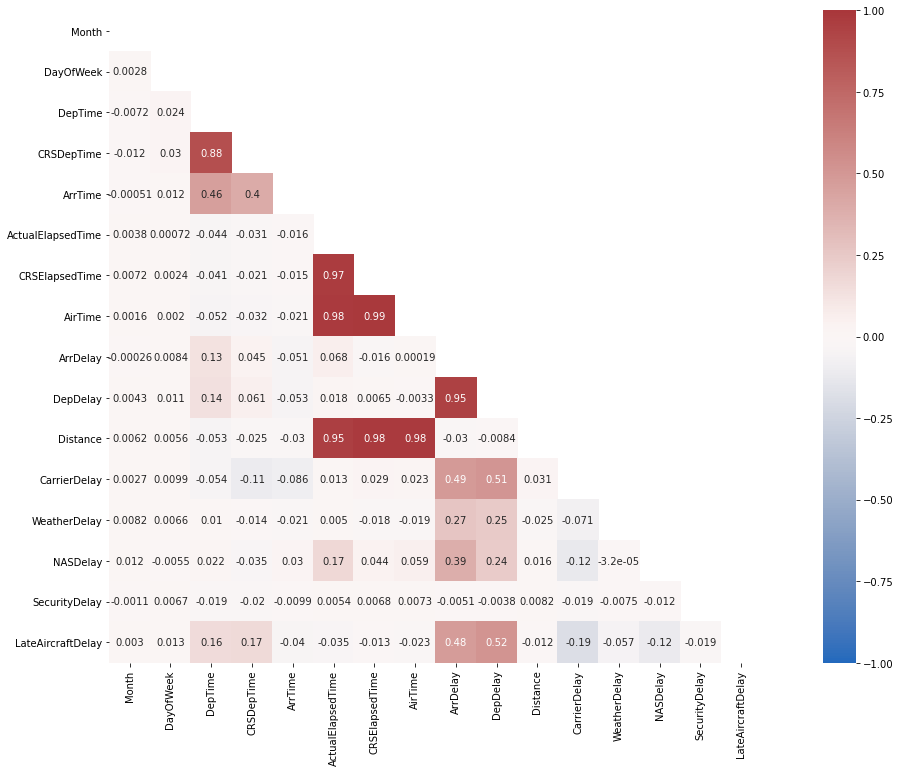

In [24]:
# analizo las relaciones entre las variables
correlac = df.corr()
mascara = np.triu(correlac)
f, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(correlac, square=True, mask=mascara, annot=True, cmap='vlag', vmin=-1, vmax=1);
plt.show()

In [25]:
df = df.drop(["ActualElapsedTime", 'CRSElapsedTime', 'AirTime'],1) # están altamente relacionadas con Distance
df = df.drop("CRSDepTime",1) # relacionada con DepTime
df.head()

,Month,DayOfWeek,DepTime,ArrTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,10,3,1426,1518,3,6,213,nan,nan,nan,nan,nan
1,10,6,1608,1837,-20,6,589,nan,nan,nan,nan,nan
2,12,6,1819,2104,4,14,647,nan,nan,nan,nan,nan
3,2,6,2205,2321,21,25,689,21,0,0,0,0
4,12,7,1452,1628,58,52,843,6,0,6,0,46


In [26]:
# saco los horarios de llegada porque no los voy a conocer en la estimación
df.drop('ArrTime',1, inplace= True)

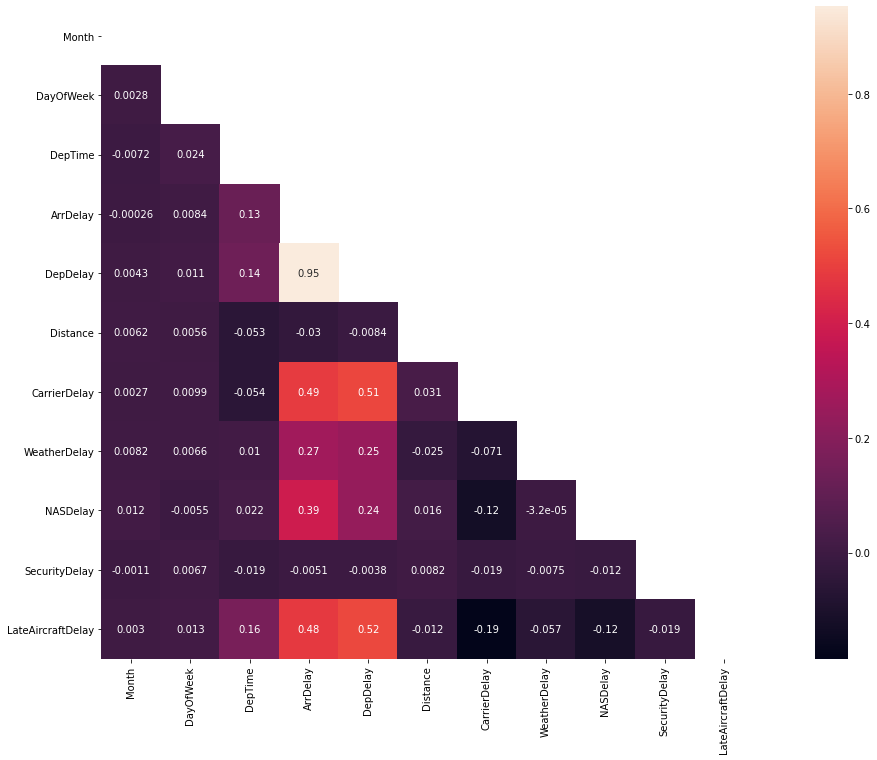

In [27]:
# analizo las variables que me quedan
correlac = df.corr()
mascara = np.triu(correlac)
f, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(correlac, square=True, mask=mascara, annot=True);
plt.show()

In [28]:
df

,Month,DayOfWeek,DepTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,10,3,1426,3,6,213,nan,nan,nan,nan,nan
1,10,6,1608,-20,6,589,nan,nan,nan,nan,nan
2,12,6,1819,4,14,647,nan,nan,nan,nan,nan
3,2,6,2205,21,25,689,21,0,0,0,0
4,12,7,1452,58,52,843,6,0,6,0,46
...,...,...,...,...,...,...,...,...,...,...,...
248930,1,3,1918,-18,13,987,nan,nan,nan,nan,nan
248931,5,3,900,28,15,887,0,0,13,0,15
248932,2,4,1945,85,50,1307,0,0,35,0,50
248933,3,7,2223,2,18,631,nan,nan,nan,nan,nan


In [29]:
# hay valores nulos?
df.isnull().sum()

Month                    0
DayOfWeek                0
DepTime                  0
ArrDelay                 0
DepDelay                 0
Distance                 0
CarrierDelay         88284
WeatherDelay         88284
NASDelay             88284
SecurityDelay        88284
LateAircraftDelay    88284
dtype: int64

In [30]:
len(df[(df['CarrierDelay'].isnull()) & (df['WeatherDelay'].isnull()) & (df['NASDelay'].isnull()) & (df['SecurityDelay'].isnull())
   & (df['LateAircraftDelay'].isnull())])

88284

Las observaciones que tienen null en una de las variables con nulos, tienen null en todas. Qué pasa con ArrDelay en esos casos?

<AxesSubplot:>

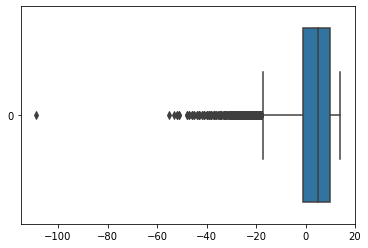

In [31]:
# Cómo se distribuye la variable ArrDelay cuando no hay información de CarrierDelay y demás?
sns.boxplot(data = df.ArrDelay[df['CarrierDelay'].isnull()], orient = 'h')

Se trata de los vuelos que llegaron con menos de 15 minutos de demora. Si completo CarrierDelay y demás con el promedio voy a tener valores que no tienen sentido. Los voy a completar con valores 0. 

In [32]:
# Completo los valores nulos con 0 
# Ojo que esto cambia las medias y medianas
df['CarrierDelay'].fillna(0, inplace=True)
df['WeatherDelay'].fillna(0, inplace=True)
df['NASDelay'].fillna(0, inplace=True)
df['SecurityDelay'].fillna(0, inplace=True)
df['LateAircraftDelay'].fillna(0, inplace=True)

In [33]:
# ya no quedan valores nulos
df.isnull().sum()

Month                0
DayOfWeek            0
DepTime              0
ArrDelay             0
DepDelay             0
Distance             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [34]:
df.describe()

,Month,DayOfWeek,DepTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,248935,248935,248935,248935,248935,248935,248935,248935,248935,248935,248935
mean,6,4,1518,42,43,765,12,2,10,0,16
std,3,2,451,56,53,574,36,17,28,2,36
min,1,1,1,-109,6,31,0,0,0,0,0
25%,3,2,1204,9,12,338,0,0,0,0,0
50%,6,4,1545,24,24,606,0,0,0,0,0
75%,9,6,1900,55,53,998,10,0,6,0,18
max,12,7,2400,1510,1518,4962,1510,1098,896,199,983


In [35]:
# Copio del S09 una función para contar outliers
def contar_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    outliers_bool = (df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))
    outliers = outliers_bool.sum(axis=0)
    return outliers

print('Outliers de ArrDelay:', contar_outliers(df.ArrDelay))
print('Outliers de CarrierDelay:', contar_outliers(df.CarrierDelay))
print('Outliers de SecurityDelay:', contar_outliers(df.SecurityDelay))

# veo que hay una cantidad importante de outliers, aunque no son porcentajes grandes para la cantidad de datos

Outliers de ArrDelay: 18283
Outliers de CarrierDelay: 33914
Outliers de SecurityDelay: 740


In [36]:
df.ArrDelay.describe()

count   248935
mean        42
std         56
min       -109
25%          9
50%         24
75%         55
max       1510
Name: ArrDelay, dtype: float64

In [37]:
df.CarrierDelay.describe()

count   248935
mean        12
std         36
min          0
25%          0
50%          0
75%         10
max       1510
Name: CarrierDelay, dtype: float64

<AxesSubplot:xlabel='ArrDelay', ylabel='Count'>

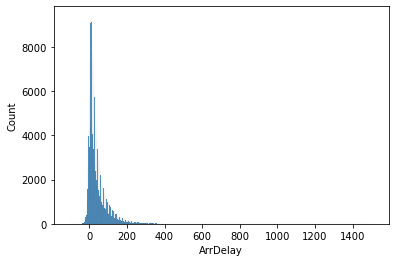

In [38]:
# Qué forma tiene la distribución de ArrDelay?
sns.histplot(data=df.ArrDelay)

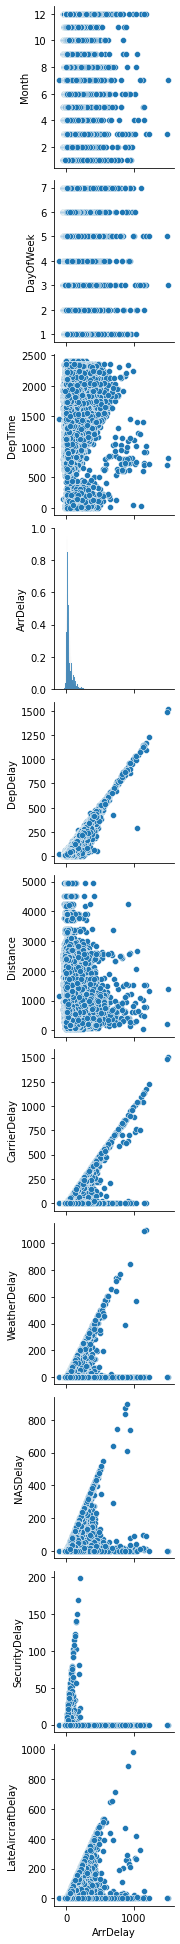

In [39]:
sns.pairplot(data=df,
                  x_vars=['ArrDelay'],
                  y_vars=df.columns)

Las variables que parecen tener una relación con ArrDelay son las que intuitivamente pensaba: DepDelay, CarrierDelay, WeatherDelay, etc.

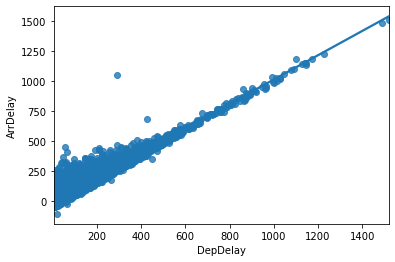

In [40]:
# Grafico la relación de DepDelay con una línea de regresión
sns.regplot(x="DepDelay", y="ArrDelay", data=df);

In [41]:
# Calculo el variance inflation factor para eliminar alguna variable más

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)


calc_vif(df)

,variables,VIF
0,Month,4
1,DayOfWeek,4
2,DepTime,6
3,ArrDelay,215
4,DepDelay,23
5,Distance,3
6,CarrierDelay,60
7,WeatherDelay,14
8,NASDelay,37
9,SecurityDelay,1


In [42]:
# El mayor valor lo tiene LateAircraftDelay y lo elimino
df.drop(['LateAircraftDelay'], axis = 1, inplace = True)

In [43]:
# Estandarizo los datos numéricos
# inicializo el Scaler
ss = StandardScaler()
# transformo los datos
valores_std = ss.fit_transform(df.values)
valores_std

array([[ 1.11892035, -0.49037238, -0.20489323, ..., -0.13827743,
        -0.34439186, -0.03582845],
       [ 1.11892035,  1.01366087,  0.19833541, ..., -0.13827743,
        -0.34439186, -0.03582845],
       [ 1.69397279,  1.01366087,  0.66581477, ..., -0.13827743,
        -0.34439186, -0.03582845],
       ...,
       [-1.1812894 ,  0.01097204,  0.94497306, ..., -0.13827743,
         0.90713066, -0.03582845],
       [-0.89376319,  1.51500528,  1.56089373, ..., -0.13827743,
        -0.34439186, -0.03582845],
       [ 1.69397279,  1.01366087, -0.0187877 , ..., -0.13827743,
         0.013186  , -0.03582845]])

In [44]:
# ahora trabajo con decimales
pd.options.display.float_format = '{:.4f}'.format
df_std = pd.DataFrame(data = valores_std, columns = df.columns)
df_std

,Month,DayOfWeek,DepTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay
0,1.1189,-0.4904,-0.2049,-0.6937,-0.7012,-0.9614,-0.3466,-0.1383,-0.3444,-0.0358
1,1.1189,1.0137,0.1983,-1.1026,-0.7012,-0.3067,-0.3466,-0.1383,-0.3444,-0.0358
2,1.6940,1.0137,0.6658,-0.6760,-0.5495,-0.2057,-0.3466,-0.1383,-0.3444,-0.0358
3,-1.1813,1.0137,1.5210,-0.3738,-0.3409,-0.1326,0.2442,-0.1383,-0.3444,-0.0358
4,1.6940,1.5150,-0.1473,0.2840,0.1713,0.1355,-0.1778,-0.1383,-0.1298,-0.0358
...,...,...,...,...,...,...,...,...,...,...
248930,-1.4688,-0.4904,0.8852,-1.0671,-0.5685,0.3862,-0.3466,-0.1383,-0.3444,-0.0358
248931,-0.3187,-0.4904,-1.3703,-0.2493,-0.5305,0.2121,-0.3466,-0.1383,0.1205,-0.0358
248932,-1.1813,0.0110,0.9450,0.7639,0.1333,0.9433,-0.3466,-0.1383,0.9071,-0.0358
248933,-0.8938,1.5150,1.5609,-0.7115,-0.4736,-0.2336,-0.3466,-0.1383,-0.3444,-0.0358


### Preparar los datos de train y test. 

Dada la alta cantidad de observaciones puedo hacer un grupo de test grande.

In [45]:
# in X we need the independent variables
# y contains the target ArrDelay

# I choose the standarized values to get X and y
X = df_std.drop('ArrDelay', axis=1)
y = df_std.ArrDelay

In [46]:
# Armo los grupos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

In [47]:
y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

## Exercici 1
Predecir ArrDelay con, al menos, 3 modelos de regresión diferentes

### Regresión lineal 

In [48]:
# creo una instancia del modelo y lo entreno con los datos de train
modelLR = LinearRegression().fit(X_train, y_train)
print('Intercept: ', modelLR.intercept_)
print('Coefs: ', modelLR.coef_)

Intercept:  -0.00043187760009671776
Coefs:  [-5.12807835e-03 -3.69981455e-04 -2.40605981e-05  8.26568478e-01
 -2.21967479e-02  8.50331931e-02  6.00042307e-02  1.93580044e-01
  5.37269604e-03]


In [49]:
# calculo el R2
modelLR.score(X_test, y_test)


0.9369063353409534

In [50]:
# los valores estimados por el modelo son: 
pred = modelLR.predict(X_test)


In [51]:
# Muestro los resultados reales contra los estimados
pd.DataFrame({'Real': y_test, 'Estimado': list(pred)})


,Real,Estimado
0,-0.0360,-0.0427
1,-0.9248,-0.6759
2,-0.6582,-0.6590
3,0.3373,0.5188
4,2.1861,2.3272
...,...,...
74676,-0.8893,-0.6711
74677,-0.4626,-0.5480
74678,0.9595,0.8103
74679,-0.3382,-0.4098


### Regresión lineal después de aplicar PCA

In [52]:
# También puedo probar la misma regresión lineal, reduciendo la cantidad de variables con PCA:
# Conservo 97% de la variabilidad
from sklearn.decomposition import PCA
# creo una instancia 
pca = PCA(.97)
principalComponents = pca.fit_transform(X)
X_PCA = pd.DataFrame(data = principalComponents)
X_PCA

,0,1,2,3,4,5,6,7,8
0,-0.8497,-0.2384,-0.0492,-0.3815,-0.6745,1.2056,-0.5199,0.3002,-0.1175
1,-0.7642,-0.2454,-0.2079,1.0408,-1.0386,0.4918,-0.1705,0.1243,-0.1673
2,-0.5763,-0.4165,-0.1200,1.2247,-1.4690,0.6564,-0.5010,-0.2658,-0.1161
3,0.0199,-0.4314,-1.6167,0.8078,0.4443,-0.8422,0.1541,-0.7273,-0.3958
4,-0.0359,0.0734,0.3484,1.5763,-1.5092,0.4215,-0.1353,0.3480,0.3090
...,...,...,...,...,...,...,...,...,...
248930,-0.6161,-0.2523,-0.6796,-0.4858,0.9950,-0.8829,0.1701,-0.9761,-0.1429
248931,-0.8136,0.4946,0.7396,-0.6247,0.3846,-0.1103,0.3479,0.7588,-0.0168
248932,0.2874,-0.6378,0.1131,0.0287,0.7444,-1.6362,-0.1392,-0.6333,-0.0696
248933,-0.3723,-0.8405,-1.5758,1.2833,0.1579,-0.8171,0.2012,-0.5793,-0.1573


In [53]:
# Obtuve 9 columnas en vez de 11
X = X_PCA
y = df_std.loc[:,['ArrDelay']]
# Armo los grupos de train y test
X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(X, y, test_size=0.3, random_state=9)

In [54]:
modelPCA = LinearRegression().fit(X_trainPCA, y_trainPCA)
print('Intercept: ', modelPCA.intercept_)
print('Coefs: ', modelPCA.coef_)
# calculo el R2
r_sq = modelPCA.score(X_testPCA, y_testPCA)
r_sq

Intercept:  [-0.00043188]
Coefs:  [[ 0.71476827 -0.04258646  0.08616963 -0.01807819  0.03488792 -0.03165237
  -0.02390875  0.09287584  0.44742812]]


0.9369063353409534

### Pruebo que modelos me da Pycaret


In [55]:
# Pruebo con los datos sin estandarizar
pycaret = setup(data = df, target = 'ArrDelay')

,Description,Value
0,session_id,2415
1,Target,ArrDelay
2,Original Data,"(248935, 10)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(174254, 26)"


In [56]:
# Lo corrí con pocos datos y obtuve Linear Regression, Ridge Regression, Least Angle Regression, BAyesian Ridge y Random Forest Regressor
# Con los datos completos logra trabar mi ordenador
top5 = compare_models(n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,5.1458,68.6502,8.2714,0.9783,0.5870,0.4425,11.1140
rf,Random Forest Regressor,4.9474,72.6116,8.5029,0.9770,0.5841,0.4566,44.7530
et,Extra Trees Regressor,5.1060,73.7957,8.5867,0.9767,0.5829,0.5057,88.2100
lightgbm,Light Gradient Boosting Machine,5.2964,76.3472,8.7210,0.9759,0.6019,0.4447,0.7070
gbr,Gradient Boosting Regressor,6.0295,85.2174,9.2168,0.9730,0.6155,0.4698,11.7410
dt,Decision Tree Regressor,6.5101,134.9711,11.6095,0.9573,0.6317,0.7081,0.7410
lr,Linear Regression,9.4331,192.5478,13.8728,0.9391,0.5808,0.7460,1.1060
ridge,Ridge Regression,9.4331,192.5478,13.8728,0.9391,0.5808,0.7460,0.0660
lar,Least Angle Regression,9.4331,192.5478,13.8728,0.9391,0.5808,0.7460,0.0670
br,Bayesian Ridge,9.4326,192.5479,13.8728,0.9391,0.5804,0.7460,0.4120


In [58]:
# queda pendiente probar lazyregressor para la próxima

### Ridge Regression

In [59]:
rr = Ridge(alpha=1.0)
rr.fit(X_train, y_train)
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [60]:
rr.score(X_test,y_test)

0.9369063273334655

In [61]:
print('Intercept: ', rr.intercept_)
print('Coefs: ', rr.coef_)

Intercept:  -0.00043186922805316694
Coefs:  [-5.12800468e-03 -3.69949059e-04 -2.29725012e-05  8.26560083e-01
 -2.21966292e-02  8.50375796e-02  6.00062495e-02  1.93581733e-01
  5.37280793e-03]


### Least Angle Regression

In [62]:
lar = linear_model.Lars(n_nonzero_coefs=1)
lar.fit(X_train,y_train)


Lars(copy_X=True, eps=2.220446049250313e-16, fit_intercept=True, fit_path=True,
     jitter=None, n_nonzero_coefs=1, normalize=True, precompute='auto',
     random_state=None, verbose=False)

In [63]:
lar.score(X_test,y_test)


0.8546888230179667

El score que obtengo es mucho peor al de Pycaret, debe hacer falta ajustar los hiperparámetros 

In [64]:
print('Intercept: ', lar.intercept_)
print('Coefs: ', lar.coef_)

Intercept:  -0.0002548933444219642
Coefs:  [0.         0.         0.         0.73167437 0.         0.
 0.         0.         0.        ]


### Bayesian Ridge

In [65]:
brr = BayesianRidge(compute_score=True)
brr.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=False)

In [66]:
brr.score(X_test,y_test)

0.9369063293952478

In [67]:
print('Intercept: ', brr.intercept_)
print('Coefs: ',brr.coef_)

Intercept:  -0.0004318713763918321
Coefs:  [-5.12802359e-03 -3.69957372e-04 -2.32517143e-05  8.26562237e-01
 -2.21966597e-02  8.50364540e-02  6.00057314e-02  1.93581300e-01
  5.37277922e-03]


### Random Forest Regressor

In [68]:
rf = RandomForestRegressor(random_state = 5)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

In [69]:
np.round(rf.feature_importances_, 3)

array([0.002, 0.002, 0.005, 0.903, 0.006, 0.007, 0.003, 0.072, 0.   ])

In [70]:
rf.score(X_test, y_test)

0.9755503795338845

## Exercici 2
Comparar los modelos en base al MSE y al R2

In [71]:
print('Regresión lineal')
pred = modelLR.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred)) # conviene que sea lo menor posible
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred)) # cuanto se desvían las predicciones del valor real
# penaliza mucho los errores grandes de estimación, MAE trata a todos los errores ppr igual
# Si da valores muy grandes es mejor usar RMSE
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred))) # es más usado porue los valores son más cecanos
print('R Squared: ', metrics.r2_score(y_test,pred)) # how well fits dependent variables
# es el score que usé en el ejercicio anterior
# es bueno si es cercano a 1
# no evalúa bien el overfitting
# print('Adjusted R Squared: ', modelLR.rsquared_adj) # es como R2 pero tiene en cuenta el overfitting
# lo ideal es que sea igual a R2
# Funciona cuando modelLR es una regresión lineal de Statsmodel

Regresión lineal
Mean Absolute Error: 0.16819246250596756
Mean Squared Error: 0.06184546594315493
Root Mean Squared Error: 0.24868748650294997
R Squared:  0.9369063353409534


In [72]:
print('Ridge Regression')
pred = rr.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred))

Ridge Regression
Mean Squared Error: 0.06184547379222855
R Squared:  0.9369063273334655


In [73]:
print('Least Angle Regression')
pred = lar.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred))

Least Angle Regression
Mean Squared Error: 0.14243644739557118
R Squared:  0.8546888230179667


In [74]:
print('Bayesian Ridge Regression')
pred = brr.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred))

Bayesian Ridge Regression
Mean Squared Error: 0.061845471771235026
R Squared:  0.9369063293952478


In [75]:
print('Random Forest Regressor')
pred = rf.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred))

Random Forest Regressor
Mean Squared Error: 0.02396592713438785
R Squared:  0.9755503795338845


El que da mejor resultado es el Random Forest, tal como aparece en Pycaret.

## Exercici 3
Entrenar los modelos usando distintos parámetros

### Regresión Lineal

In [76]:
# creo una instancia del modelo pero esta vez le digo que los datos están centrados y que no calcule intercept
modelLR = LinearRegression(fit_intercept= False).fit(X_train, y_train)

In [77]:
pred = modelLR.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred)) 
print('R Squared: ', metrics.r2_score(y_test,pred)) 

Mean Squared Error: 0.06184441493807666
R Squared:  0.9369074075579858


I got the same values. It makes sense because data is already standarized and intercept is 0.

### Random Forest Regressor

In [78]:
rf = RandomForestRegressor(random_state = 5, n_estimators= 50, min_samples_split=100) 
# el default del n_estimators era 100
# y el de min_samples_split =2 
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=100, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

In [79]:
pred = rf.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred))

Mean Squared Error: 0.02912029512043672
R Squared:  0.9702919832993083


The result is slightly worse but needs less calculation.

### Bayesian Ridge

In [80]:
brr = BayesianRidge(compute_score=False, n_iter = 50, normalize = True)
# el default de n_iter es 300, va a hacer menos cálculos
brr.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=50,
              normalize=True, tol=0.001, verbose=False)

In [81]:
pred = brr.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred))

Mean Squared Error: 0.06184547178895131
R Squared:  0.936906329377174


It doesn´t make a difference.

### Combinaciones automáticas de hiperparámetros 
Uso GridSearchCV para obtener distintas combinaciones de hiperparámetros para BAyesian Ridge.

The results are the same.

In [82]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {'normalize': [True, False],
             'compute_score': [True, False]}

# run grid search
grid_search = GridSearchCV(brr, param_grid=param_grid)

grid_search.fit(X_test, y_test)
grid_search.cv_results_

{'mean_fit_time': array([0.03092265, 0.02471414, 0.03517203, 0.03232255]),
 'std_fit_time': array([0.00450085, 0.00071637, 0.00551246, 0.00390949]),
 'mean_score_time': array([0.00278544, 0.0024003 , 0.00316591, 0.00339088]),
 'std_score_time': array([0.00039531, 0.00048436, 0.00043365, 0.00048844]),
 'param_compute_score': masked_array(data=[True, True, False, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_normalize': masked_array(data=[True, False, True, False],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'compute_score': True, 'normalize': True},
  {'compute_score': True, 'normalize': False},
  {'compute_score': False, 'normalize': True},
  {'compute_score': False, 'normalize': False}],
 'split0_test_score': array([0.93362737, 0.93362737, 0.93362737, 0.93362737]),
 'split1_test_score': array([0.93997043, 0.93997043, 0.93997043, 0.93997043]),
 's

In [83]:
report(grid_search.cv_results_,2)

Model with rank: 1
Mean validation score: 0.937 (std: 0.003)
Parameters: {'compute_score': True, 'normalize': True}

Model with rank: 1
Mean validation score: 0.937 (std: 0.003)
Parameters: {'compute_score': False, 'normalize': True}



These are the best two combination of the hyperparameters being evaluated. 

## Exercici 4
Analizar los resultados obtenidos usando train_test y validación interna

In [84]:
# Using the standarized data again: 
X = df_std.drop('ArrDelay', axis=1)
y = df_std.ArrDelay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

In [85]:
# All the models up to now where trained with a train/test
# For example Linear Regression
modelLR = LinearRegression().fit(X_train, y_train)
modelLR.score(X_test, y_test)

0.9370329104637473

In [86]:
pred = modelLR.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

Mean Absolute Error: 0.16785849622386206
Mean Squared Error: 0.06211977579883415


In [87]:
# Using internal validation (all the data) in the same model:
modelLR.score(X, y)

0.9391227212982891

In [88]:
pred = modelLR.predict(X)
print('Mean Absolute Error:', metrics.mean_absolute_error(y, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, pred))

Mean Absolute Error: 0.16794907592994787
Mean Squared Error: 0.06087727870171087


There´s very little difference between the results in train/test data and the the ones with internal validation. 

Before this test I tried the same with the full 2.000.000 records of the dataset. The results were almost the same for train/test and internal validation. 

In [89]:
# Hay overfitting? Cómo resulta el score para train y para test?
print('Rsquared with train data:', modelLR.score(X_train, y_train))
print('Rsquared with test data:', modelLR.score(X_test, y_test))

Rsquared with train data: 0.9398066923927166
Rsquared with test data: 0.9370329104637473


There´s no sig of verfitting :)

In [90]:
# Let´s check Bayesian Ridge with train/test:
brr = BayesianRidge(compute_score= True, normalize= False)
brr.fit(X_train, y_train)

brr.score(X_test, y_test)

0.9370329282150768

In [91]:
pred = brr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

Mean Absolute Error: 0.16785869632183562
Mean Squared Error: 0.06211975828637452


In [92]:
# And now with internal validation:
brr.score(X, y)

0.9391227256637843

In [93]:
pred = brr.predict(X)
print('Mean Absolute Error:', metrics.mean_absolute_error(y, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, pred))

Mean Absolute Error: 0.1679492844763374
Mean Squared Error: 0.06087727433621574


The results are very similar. 


In [94]:
# And now using Random Forest (train/test)
rf = RandomForestRegressor(random_state = 5)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9753332817086178

In [95]:
pred = rf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

Mean Absolute Error: 0.08811156921449953
Mean Squared Error: 0.024334791733886026


In [96]:
# and internal validation
pred = rf.predict(X)
print('Mean Absolute Error:', metrics.mean_absolute_error(y, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, pred))
rf.score(X, y)

Mean Absolute Error: 0.046513232722845445
Mean Squared Error: 0.008381389410701509


0.9916186105892985

### With Random Forest all the results with internal validation are much better than with train/test

In [97]:
# Hay overfitting? Cómo resulta el score para train y para test?
print('Rsquared with train data:', rf.score(X_train, y_train))
print('Rsquared with test data:', rf.score(X_test, y_test))

Rsquared with train data: 0.9969501103021247
Rsquared with test data: 0.9753332817086178


In [98]:
# the results are better for train but are also very good for test data. 

## Exercici 5
Procesar las variables para obtener mejores resultados
De todos los modelos usados Random Forest está dando el mejor resultado. Uso este modelo para probar distintas versiones de los datos de entrada.

### Random Forest standarized with less variables

In [99]:
# Until now  I´ve been using the standarized vales

In [100]:
X

,Month,DayOfWeek,DepTime,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay
0,1.1189,-0.4904,-0.2049,-0.7012,-0.9614,-0.3466,-0.1383,-0.3444,-0.0358
1,1.1189,1.0137,0.1983,-0.7012,-0.3067,-0.3466,-0.1383,-0.3444,-0.0358
2,1.6940,1.0137,0.6658,-0.5495,-0.2057,-0.3466,-0.1383,-0.3444,-0.0358
3,-1.1813,1.0137,1.5210,-0.3409,-0.1326,0.2442,-0.1383,-0.3444,-0.0358
4,1.6940,1.5150,-0.1473,0.1713,0.1355,-0.1778,-0.1383,-0.1298,-0.0358
...,...,...,...,...,...,...,...,...,...
248930,-1.4688,-0.4904,0.8852,-0.5685,0.3862,-0.3466,-0.1383,-0.3444,-0.0358
248931,-0.3187,-0.4904,-1.3703,-0.5305,0.2121,-0.3466,-0.1383,0.1205,-0.0358
248932,-1.1813,0.0110,0.9450,0.1333,0.9433,-0.3466,-0.1383,0.9071,-0.0358
248933,-0.8938,1.5150,1.5609,-0.4736,-0.2336,-0.3466,-0.1383,-0.3444,-0.0358


In [101]:
y

0        -0.6937
1        -1.1026
2        -0.6760
3        -0.3738
4         0.2840
           ...  
248930   -1.0671
248931   -0.2493
248932    0.7639
248933   -0.7115
248934    0.1418
Name: ArrDelay, Length: 248935, dtype: float64

In [102]:
# After aplaying Random Forest I got:
np.round(rf.feature_importances_, 3)

array([0.002, 0.002, 0.005, 0.902, 0.006, 0.007, 0.003, 0.072, 0.   ])

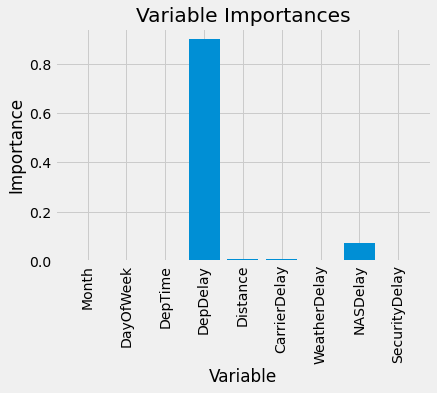

In [103]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(rf.feature_importances_)))
# Make a bar chart
plt.bar(x_values, rf.feature_importances_, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, X.columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [104]:
# The most important features are DepDelay and NASDelay, and then Distance. Lets keep only the ones greater than 0.002
X_red = X.drop(['Month', 'DayOfWeek','DepTime','SecurityDelay'], axis=1)

In [105]:
X_red

,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay
0,-0.7012,-0.9614,-0.3466,-0.1383,-0.3444
1,-0.7012,-0.3067,-0.3466,-0.1383,-0.3444
2,-0.5495,-0.2057,-0.3466,-0.1383,-0.3444
3,-0.3409,-0.1326,0.2442,-0.1383,-0.3444
4,0.1713,0.1355,-0.1778,-0.1383,-0.1298
...,...,...,...,...,...
248930,-0.5685,0.3862,-0.3466,-0.1383,-0.3444
248931,-0.5305,0.2121,-0.3466,-0.1383,0.1205
248932,0.1333,0.9433,-0.3466,-0.1383,0.9071
248933,-0.4736,-0.2336,-0.3466,-0.1383,-0.3444


In [106]:
# Let´s apply Random Forest again
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y, test_size=0.3, random_state=9)

In [107]:
# Run Random Forest
rf_red = RandomForestRegressor(random_state = 5)
rf_red.fit(X_train_red, y_train_red)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

In [108]:
print('Random Forest Regressor complete')
pred = rf.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('R Squared: ', metrics.r2_score(y_test,pred), '\n')

print('Random Forest Regressor reduced (with less variables)')
pred_red = rf_red.predict(X_test_red)
print('Mean Squared Error:', metrics.mean_squared_error(y_test_red, pred_red))
print('R Squared: ', metrics.r2_score(y_test_red,pred_red))

Random Forest Regressor complete
Mean Squared Error: 0.024334791733886026
R Squared:  0.9753332817086178 

Random Forest Regressor reduced (with less variables)
Mean Squared Error: 0.02590039301780808
R Squared:  0.9735768712114624


### Random Forest with normalized variables

In [109]:
# What about using nomalization instead of standarazation?

# normalize the data
valores_norm = normalize(df.values)
valores_norm

array([[6.93542149e-03, 2.08062645e-03, 9.88991104e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.83891758e-03, 3.50335055e-03, 9.38897947e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.21522933e-03, 3.10761466e-03, 9.42125179e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.52628947e-04, 1.70525789e-03, 8.29181651e-01, ...,
        0.00000000e+00, 1.49210066e-02, 0.00000000e+00],
       [1.29819342e-03, 3.02911798e-03, 9.61961323e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.88730503e-03, 3.94365251e-03, 9.92485883e-01, ...,
        0.00000000e+00, 6.57275419e-03, 0.00000000e+00]])

In [110]:
df_norm = pd.DataFrame(data = valores_norm, columns = df.columns)
df_norm

,Month,DayOfWeek,DepTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay
0,0.0069,0.0021,0.9890,0.0021,0.0042,0.1477,0.0000,0.0000,0.0000,0.0000
1,0.0058,0.0035,0.9389,-0.0117,0.0035,0.3439,0.0000,0.0000,0.0000,0.0000
2,0.0062,0.0031,0.9421,0.0021,0.0073,0.3351,0.0000,0.0000,0.0000,0.0000
3,0.0009,0.0026,0.9543,0.0091,0.0108,0.2982,0.0091,0.0000,0.0000,0.0000
4,0.0071,0.0042,0.8638,0.0345,0.0309,0.5015,0.0036,0.0000,0.0036,0.0000
...,...,...,...,...,...,...,...,...,...,...
248930,0.0005,0.0014,0.8891,-0.0083,0.0060,0.4575,0.0000,0.0000,0.0000,0.0000
248931,0.0040,0.0024,0.7120,0.0221,0.0119,0.7017,0.0000,0.0000,0.0103,0.0000
248932,0.0009,0.0017,0.8292,0.0362,0.0213,0.5572,0.0000,0.0000,0.0149,0.0000
248933,0.0013,0.0030,0.9620,0.0009,0.0078,0.2731,0.0000,0.0000,0.0000,0.0000


In [111]:
# Use the normalized values to get X and y
X_norm = df_norm.drop('ArrDelay', axis=1)
y_norm = df_norm.ArrDelay

In [112]:
# Let´s apply Random Forest again
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.3, random_state=9)

In [113]:
# Run Random Forest
rf_norm = RandomForestRegressor(random_state = 5)
rf_norm.fit(X_train_norm, y_train_norm)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

In [114]:
print('Random Forest Regressor normalized')
pred_norm = rf_norm.predict(X_test_norm)
print('Mean Squared Error:', metrics.mean_squared_error(y_test_norm, pred_norm))
print('R Squared: ', metrics.r2_score(y_test_norm,pred_norm))

Random Forest Regressor normalized
Mean Squared Error: 2.5158706714927127e-05
R Squared:  0.9820109500035376


The result is better :))

### Linear Regression with normalized variables

In [115]:
# Run Linear Regression
lr_norm = LinearRegression()
lr_norm.fit(X_train_norm, y_train_norm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [116]:
print('Linear Regression normalized')
pred_norm = lr_norm.predict(X_test_norm)
print('Mean Squared Error:', metrics.mean_squared_error(y_test_norm, pred_norm))
print('R Squared: ', metrics.r2_score(y_test_norm,pred_norm))

Linear Regression normalized
Mean Squared Error: 7.027625294601734e-05
R Squared:  0.9497508738372521


### Transformación no lineal: quantile_transform

In [117]:
# Using a non linear transformation

valores_unif = quantile_transform(df.values, output_distribution = 'uniform')
valores_unif

array([[0.81531532, 0.35285285, 0.40540541, ..., 0.        , 0.        ,
        0.        ],
       [0.81531532, 0.7952953 , 0.52752753, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.7952953 , 0.6976977 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14614615, 0.495996  , 0.80730731, ..., 0.        , 0.92342342,
        0.        ],
       [0.24724725, 1.        , 0.96846847, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.7952953 , 0.45695696, ..., 0.        , 0.8003003 ,
        0.        ]])

In [118]:
df_unif = pd.DataFrame(data = valores_unif, columns = df.columns)
df_unif

,Month,DayOfWeek,DepTime,ArrDelay,DepDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay
0,0.8153,0.3529,0.4054,0.1456,0.0000,0.0936,0.0000,0.0000,0.0000,0.0000
1,0.8153,0.7953,0.5275,0.0040,0.0000,0.4765,0.0000,0.0000,0.0000,0.0000
2,1.0000,0.7953,0.6977,0.1627,0.3043,0.5385,0.0000,0.0000,0.0000,0.0000
3,0.1461,0.7953,0.9560,0.4560,0.5110,0.5676,0.8403,0.0000,0.0000,0.0000
4,1.0000,1.0000,0.4354,0.7628,0.7447,0.6547,0.7132,0.0000,0.7503,0.0000
...,...,...,...,...,...,...,...,...,...,...
248930,0.0000,0.3529,0.7733,0.0055,0.2788,0.7412,0.0000,0.0000,0.0000,0.0000
248931,0.4179,0.3529,0.0921,0.5460,0.3308,0.6847,0.0000,0.0000,0.8283,0.0000
248932,0.1461,0.4960,0.8073,0.8564,0.7337,0.8524,0.0000,0.0000,0.9234,0.0000
248933,0.2472,1.0000,0.9685,0.1296,0.3954,0.5220,0.0000,0.0000,0.0000,0.0000


In [119]:
# Use the normalized values to get X and y
X_unif = df_unif.drop('ArrDelay', axis=1)
y_unif = df_unif.ArrDelay

In [120]:
# Let´s apply Random Forest again
X_train_unif, X_test_unif, y_train_unif, y_test_unif = train_test_split(X_unif, y_unif, test_size=0.3, random_state=9)
# Run Random Forest
rf_unif = RandomForestRegressor(random_state = 5)
rf_unif.fit(X_train_unif, y_train_unif)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

In [121]:
print('Random Forest Regressor non linear')
pred_unif = rf_unif.predict(X_test_unif)
print('Mean Squared Error:', metrics.mean_squared_error(y_test_unif, pred_unif))
print('R Squared: ', metrics.r2_score(y_test_unif,pred_unif))

Random Forest Regressor non linear
Mean Squared Error: 0.005330192938602625
R Squared:  0.9359807617723761


The result is worse

## Exercici 6

Calcular las predicciones sin usar DepDelay

In [122]:
# Up to know the best results were using normalized data
# Also we know Month and DAyOfWeek are useless
# Dropping them all we get:
df_ex6 = df_norm.drop(['DepDelay','Month','DayOfWeek'], axis=1)
df_ex6

,DepTime,ArrDelay,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay
0,0.9890,0.0021,0.1477,0.0000,0.0000,0.0000,0.0000
1,0.9389,-0.0117,0.3439,0.0000,0.0000,0.0000,0.0000
2,0.9421,0.0021,0.3351,0.0000,0.0000,0.0000,0.0000
3,0.9543,0.0091,0.2982,0.0091,0.0000,0.0000,0.0000
4,0.8638,0.0345,0.5015,0.0036,0.0000,0.0036,0.0000
...,...,...,...,...,...,...,...
248930,0.8891,-0.0083,0.4575,0.0000,0.0000,0.0000,0.0000
248931,0.7120,0.0221,0.7017,0.0000,0.0000,0.0103,0.0000
248932,0.8292,0.0362,0.5572,0.0000,0.0000,0.0149,0.0000
248933,0.9620,0.0009,0.2731,0.0000,0.0000,0.0000,0.0000


In [123]:
# Use the normalized and reduced values to get X and y
X_ex6 = df_ex6.drop('ArrDelay', axis=1)
y_ex6 = df_ex6.ArrDelay
# Let´s apply train/test
X_train_ex6, X_test_ex6, y_train_ex6, y_test_ex6 = train_test_split(X_ex6, y_ex6, test_size=0.3, random_state=9)

In [124]:
# Run Random Forest
rf_ex6 = RandomForestRegressor(random_state = 5)
rf_ex6.fit(X_train_ex6, y_train_ex6)

print('Random Forest Regressor normalized without DepDelay')
pred_ex6 = rf_ex6.predict(X_test_ex6)
print('Mean Squared Error:', metrics.mean_squared_error(y_test_ex6, pred_ex6))
print('R Squared: ', metrics.r2_score(y_test_ex6,pred_ex6))

Random Forest Regressor normalized without DepDelay
Mean Squared Error: 9.884725218165996e-05
R Squared:  0.9293219567421647


In [125]:
# The results are also good. What´s happening is that XXXDelay has almost the same information as DepDelay

### Pruebo con una red neuronal

In [126]:
# construct and train the neural network
mlp = MLPRegressor(hidden_layer_sizes=(100,50,50), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train_ex6,y_train_ex6)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 50, 50), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [127]:
# predict results for train and test data
predict_train = mlp.predict(X_train_ex6)
predict_test = mlp.predict(X_test_ex6)

In [128]:
print('Mean Squared Error for test set:', metrics.mean_squared_error(y_test_ex6, predict_test))
print('R Squared for test set: ', metrics.r2_score(y_test_ex6,predict_test))

Mean Squared Error for test set: 0.00011894453046519081
R Squared for test set:  0.9149519436913447


In [129]:
print('Mean Squared Error for train set:', metrics.mean_squared_error(y_train_ex6, predict_train))
print('R Squared for train set: ', metrics.r2_score(y_train_ex6,predict_train))

Mean Squared Error for train set: 0.00011978928055101347
R Squared for train set:  0.9177604863227528


With these errors we check that the network is not overfitted. 

Anyway the result is not so good as with random forest. 